Imports & Paths

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Dataset Paths

In [2]:
BASE_DIR = r"F:\Project\GPU\CV\brain2"

TRAIN_DIR = os.path.join(BASE_DIR, "Training")
TEST_DIR  = os.path.join(BASE_DIR, "Testing")

SEGMENTED_BASE = os.path.join(BASE_DIR, "Segmented")
SEG_TRAIN = os.path.join(SEGMENTED_BASE, "Training")
SEG_TEST  = os.path.join(SEGMENTED_BASE, "Testing")

IMG_SIZE = 224


Median Filtering Function

In [3]:
def apply_median_filter(image):
    return cv2.medianBlur(image, 5)


Apply Median Filter to Dataset (SAVE)

In [4]:
def preprocess_and_save(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for cls in os.listdir(input_dir):
        cls_path = os.path.join(input_dir, cls)
        out_cls_path = os.path.join(output_dir, cls)
        os.makedirs(out_cls_path, exist_ok=True)

        for img_name in tqdm(os.listdir(cls_path), desc=f"Processing {cls}"):
            img_path = os.path.join(cls_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                continue

            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            filtered = apply_median_filter(img)

            cv2.imwrite(os.path.join(out_cls_path, img_name), filtered)


Run Median Filtering

In [5]:
preprocess_and_save(TRAIN_DIR, SEG_TRAIN)
preprocess_and_save(TEST_DIR, SEG_TEST)


Processing pituitary: 100%|██████████| 300/300 [00:03<00:00, 89.86it/s]


Visualize Median Filter (Before vs After)

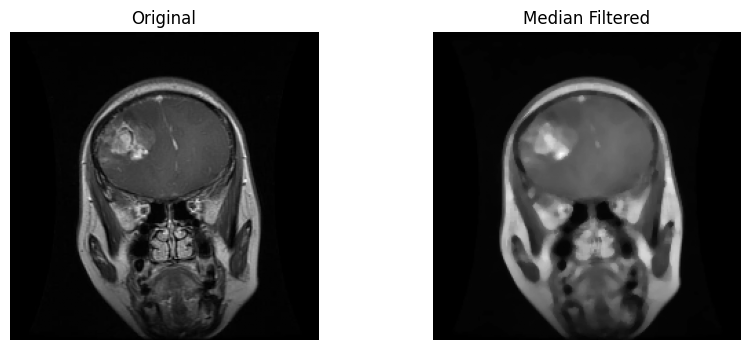

In [6]:
sample_class = "glioma"
sample_img = os.listdir(os.path.join(TRAIN_DIR, sample_class))[0]

img = cv2.imread(os.path.join(TRAIN_DIR, sample_class, sample_img), 0)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
filtered = apply_median_filter(img)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(filtered, cmap='gray')
plt.title("Median Filtered")
plt.axis("off")
plt.show()


U-Net Model

In [7]:
def build_unet(input_shape=(224,224,1)):
    inputs = layers.Input(input_shape)

    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)

    u1 = layers.UpSampling2D()(c3)
    m1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(m1)

    u2 = layers.UpSampling2D()(c4)
    m2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(m2)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    return models.Model(inputs, outputs)


Load Images for Segmentation

In [8]:
def load_images_for_segmentation(folder):
    images = []
    paths = []

    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            img = cv2.imread(img_path, 0)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
            paths.append((cls, img_name))

    images = np.array(images) / 255.0
    return images[..., np.newaxis], paths


Train U-Net (Autoencoder-style)

In [9]:
X_seg, paths = load_images_for_segmentation(SEG_TRAIN)

unet = build_unet()
unet.compile(optimizer='adam', loss='binary_crossentropy')

unet.fit(X_seg, X_seg, epochs=5, batch_size=8)


Epoch 1/5
714/714 ━━━━━━━━━━━━━━━━━━━━ 742s 1s/step - loss: 0.3519
Epoch 2/5
714/714 ━━━━━━━━━━━━━━━━━━━━ 945s 1s/step - loss: 0.3444
Epoch 3/5
714/714 ━━━━━━━━━━━━━━━━━━━━ 968s 1s/step - loss: 0.3442
Epoch 4/5
714/714 ━━━━━━━━━━━━━━━━━━━━ 379s 531ms/step - loss: 0.3443
Epoch 5/5
714/714 ━━━━━━━━━━━━━━━━━━━━ 1285s 2s/step - loss: 0.3442


Save Segmented Outputs

In [10]:
def save_segmented_images(model, X, paths, base_out):
    for i in range(len(X)):
        cls, name = paths[i]
        out_dir = os.path.join(base_out, cls)
        os.makedirs(out_dir, exist_ok=True)

        pred = model.predict(X[i:i+1])[0]
        mask = (pred > 0.5).astype(np.uint8) * 255

        cv2.imwrite(os.path.join(out_dir, name), mask)

save_segmented_images(unet, X_seg, paths, SEG_TRAIN)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


KeyboardInterrupt: 

Data Generators

In [3]:
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    SEG_TRAIN,
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16
)

test_gen = datagen.flow_from_directory(
    SEG_TEST,
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


EfficientNet Classifier

In [4]:
base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False

model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Train Classifier

In [5]:
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=test_gen
)


Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 269s 729ms/step - accuracy: 0.2806 - loss: 1.3852 - val_accuracy: 0.2654 - val_loss: 1.3829
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 327s 919ms/step - accuracy: 0.3613 - loss: 1.3273 - val_accuracy: 0.2304 - val_loss: 1.4122
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 290s 815ms/step - accuracy: 0.3881 - loss: 1.2870 - val_accuracy: 0.2288 - val_loss: 1.5289
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 144s 401ms/step - accuracy: 0.4065 - loss: 1.2561 - val_accuracy: 0.2288 - val_loss: 1.5613
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 176s 493ms/step - accuracy: 0.4259 - loss: 1.2281 - val_accuracy: 0.2288 - val_loss: 1.6458
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 115s 323ms/step - accuracy: 0.4293 - loss: 1.2150 - val_accuracy: 0.2288 - val_loss: 1.5650
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - accuracy: 0.4461 - loss: 1.1885 - val_accuracy: 0.2304 - val_loss: 1.5579
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 196s 489ms/step - accuracy: 0.4382 - lo

Evaluation & Confusion Matrix

In [ ]:
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_gen.classes, y_pred_classes)
disp = ConfusionMatrixDisplay(cm, display_labels=test_gen.class_indices.keys())
disp.plot(cmap='Blues')
plt.show()


In [ ]:
model.save(r"F:\Project\GPU\CV\brain2\brain_tumor_classifier.h5")
unet.save(r"F:\Project\GPU\CV\brain2\unet_segmenter.h5")
